# Marketing Budget Allocation

Goal - Use linear programming to build a simple marketing budget allocation strategy.

In [280]:
import numpy as np
import pandas as pd
import gurobipy as gp
import matplotlib.pyplot as plt
import calendar

**Creating general function for optimizing (Max or Min) based on constraint equations**

In [2]:
def create_model(A, sense, b, obj, opt=gp.GRB.MAXIMIZE):
    # creating model
    model = gp.Model()

    # creating variable an setting the constraints
    modx = model.addMVar(A.shape[1])
    mod_con = model.addMConstrs(A, modx, sense, b)

    # setting the objective function
    model.setMObjective(None, obj, 0, sense=opt)

    # restricting gurobi logs
    model.Params.OutputFlag = 0

    # optimizing the function
    model.optimize()
    
    return model

## ROI optimization using first estimates

Assume that your company is deciding how to spend a marketing budget of $10M.  You work in the marketing department as a data scientist and the chief marketing officer has asked you write a report recommending how to spread this budget among several marketing mediums.  Your department has employed an outside consulting firm to estimate the return on investment (ROI) of each marketing medium under consideration.  The results are in the table below, and also in a CSV attached to this assignment:

In [3]:
# reading the ROI data from two different firms
roi_df = pd.read_csv('ROI_data.csv')

# creating numpy array for model usage
roi = roi_df[roi_df['Platform'] == 'ROI'].values[0, 1:]
second_roi = roi_df[roi_df['Platform'] != 'ROI'].values[0, 1:]

# variable for total budget
total_budget = 10000000

roi_df

,Platform,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
0,ROI,0.031,0.049,0.024,0.039,0.016,0.024,0.046,0.026,0.033,0.044
1,Second Firms ROI Estimate,0.049,0.023,0.024,0.039,0.044,0.046,0.026,0.019,0.037,0.026


On top of these ROIs, your boss has decided to constrain your budget as follows:
1.	The amount invested in print and TV should be no more than the amount spent on Facebook and Email. Surprisingly, email seems to be a great channel for reaching real people.
2.	The total amount used in social media (Facebook, LinkedIn, Instagram, Snapchat, and Twitter) should be at least twice of SEO and AdWords.
3.	For each platform, the amount invested should be no more than $3M.


Assuming variables $x_0$ to $x_{9}$ to be the fraction of total budget for different platforms - from Print to Email in the above csv

**Equation in LaTeX - TODO**

In [4]:
# initializing constraint matrix and constraint limit and directions
A = np.zeros((13, 10))
b = np.zeros(13)
sense = ['']*13

# Constraint 1:
# total_budget*(x_0 + x_1) - total_budget*(x_4 + x_9) <= 0
A[0, 0] = 1
A[0, 1] = 1
A[0, 4] = -1
A[0, 9] = -1
b[0] = 0
sense[0] = '<'

# Constraint 2:
# total_budget*(x_4 + x_5 + x_6 + x_7 + x_8) - 2*total_budget*(x_2 + x_3) >= 0
A[1, 4:9] = 1
A[1, 2:4] = -2
b[1] = 0
sense[1] = '>'

# Constraint 3 to 12:
# x_i <= 0.3
for i in range(10):
    A[i+2, i] = 1
    b[i+2] = 0.3
    sense[i+2] = '<'

# Constraint 13:
# sum of all x_i <= 1
A[12, :] = 1
b[12] = 1
sense[12] = '<'

A, sense, b

(array([[ 1.,  1.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.],
        [ 0.,  0., -2., -2.,  1.,  1.,  1.,  1.,  1.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]]),
 ['<', '>', '<', '<', '<', '<', '<', '<', '<', '<', '<', '<', '<'],
 array([0. , 0. , 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 1. ]))

Formulate the marketing budget allocation problem as a linear program.  Use gurobi to find the optimal budget allocation.

In [5]:
# creating advertising model for first estimates
adv_model = create_model(A, sense, b, obj=roi, opt=gp.GRB.MAXIMIZE)

Academic license - for non-commercial use only - expires 2022-08-21
Using license file C:\gurobi912\gurobi.lic


<ipython-input-5-038dee29a028>:2: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  adv_model = create_model(A, sense, b, obj=roi, opt=gp.GRB.MAXIMIZE)


In [6]:
# creating an output df with different firms ROI for Platform allocation
output_df = roi_df.T.reset_index()
output_df.columns = output_df.iloc[0]
output_df = output_df.iloc[1:]

# creating new column in output df for budget allocation
output_df['Allocation'] = adv_model.x

**Platform wise allocation based on ROI maximisation for the marketing budget is below**

In [7]:
output_df[['Platform', 'Allocation']]

,Platform,Allocation
1,Print,0.0
2,TV,0.3
3,SEO,0.0
4,AdWords,0.1
5,Facebook,0.0
6,LinkedIn,0.0
7,Instagram,0.3
8,Snapchat,0.0
9,Twitter,0.0
10,Email,0.3


In [8]:
first_firms_roi_pct = round(adv_model.objVal*100,3)
first_firms_roi = round(adv_model.objVal*total_budget)
print('Total ROI from ${} marketing budget is {} dollars which is {}%'.format(
    total_budget, first_firms_roi, first_firms_roi_pct))

Total ROI from $10000000 marketing budget is 456000 dollars which is 4.56%


Your boss is happy to see the promising results presented by the marketing department. However, your boss is also very concerned because your boss recalls being somewhat disappointed after following such recommendations in the past. To be cautious about the decision, your team has decided to get another opinion about the ROI data and rerun the analysis.  The second consulting firm returns the estimates of the ROI data in the table below (also in the CSV file mentioned above).  You are asked to compare the two optimal allocations from these two ROI estimates.  

## ROI optimization using second firm's estimates

In [9]:
# creating advertising model for second estimates
adv_model2 = create_model(A, sense, b, obj=second_roi, opt=gp.GRB.MAXIMIZE)

<ipython-input-9-3f7373cb1b73>:2: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  adv_model2 = create_model(A, sense, b, obj=second_roi, opt=gp.GRB.MAXIMIZE)


In [10]:
# creating new column in output df for budget allocation
output_df['Second Allocation'] = adv_model2.x

**Platform wise allocation based on ROI maximisation using second ROI for the marketing budget is below**

In [11]:
output_df[['Platform', 'Second Allocation']]

,Platform,Second Allocation
1,Print,0.3
2,TV,0.0
3,SEO,0.0
4,AdWords,0.1
5,Facebook,0.3
6,LinkedIn,0.3
7,Instagram,0.0
8,Snapchat,0.0
9,Twitter,0.0
10,Email,0.0


In [12]:
second_firms_roi_pct = round(adv_model2.objVal*100,3)
second_firms_roi = round(adv_model2.objVal*total_budget)
print('Total ROI from ${} marketing budget is {} dollars which is {}%'.format(
    total_budget, second_firms_roi, second_firms_roi_pct))

Total ROI from $10000000 marketing budget is 456000 dollars which is 4.56%


## Budget allocation and optimal ROI for First firm's vs Second firm's estimates

Are the allocations the same? 
**No allocation are not the same**

Assuming the first ROI data is correct, if you were to use the second allocation (the allocation that assumed the second ROI data was correct) how much lower would the objective be relative to the optimal objective (the one that uses the first ROI data and the first allocation)?  
**Objective is lower by 204,000**

Assuming the second ROI data is correct, if you used the first allocation how much lower would the objective be relative to the optimal objective?  
**Objective is lower by 192,000**

Do you think the third constraint above, based on your boss’ experience, is useful?

In [149]:
diff1 = round(total_budget*(sum(roi*output_df['Allocation']) - sum(roi*output_df['Second Allocation'])), 2)
print(diff1)

diff2 = round(total_budget*(sum(second_roi*output_df['Second Allocation']) - sum(second_roi*output_df['Allocation'])), 2)
print(diff2)

204000.0
192000.0


In [146]:
if sum(output_df['ROI'] * output_df['Allocation']) == sum(
    output_df['Second Firms ROI Estimate'] * output_df['Second Allocation']):
    print('Maximum ROI obtainied using optimized allocation for both firm"s estimates are same')

Maximum ROI obtainied using optimized allocation for both firm"s estimates are same


**Budge allocation comaprision using first vs second firm's estimate**

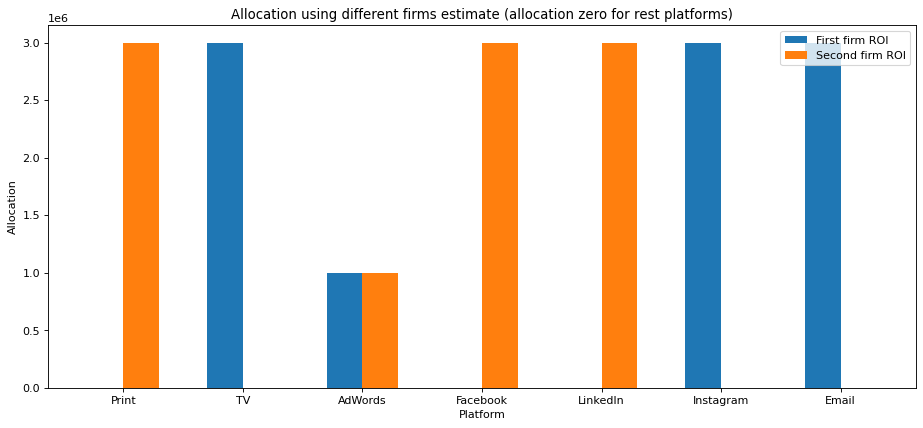

In [357]:
# plotting different firm allocation
plt.figure(figsize=(14, 6), dpi=80)
allocation_df = output_df.loc[(output_df['Allocation'] > 0) | (output_df['Second Allocation'] > 0) ,
                              ['Platform', 'Allocation', 'Second Allocation']]

width = 0.3
ind = ind = np.arange(len(allocation_df))
plt.xticks(ind + width / 2, allocation_df['Platform'])
plt.bar(ind, allocation_df['Allocation']*total_budget, label='First firm ROI', width=width)
plt.bar(ind + width, allocation_df['Second Allocation']*total_budget, label='Second firm ROI', width=width)

plt.xlabel('Platform')
plt.ylabel('Allocation')
plt.title('Allocation using different firms estimate (allocation zero for rest platforms)')
plt.legend()
plt.savefig('figure/allocation_for_different_estimates.jpeg')
plt.show()

**Overall ROI comparision**

No handles with labels found to put in legend.


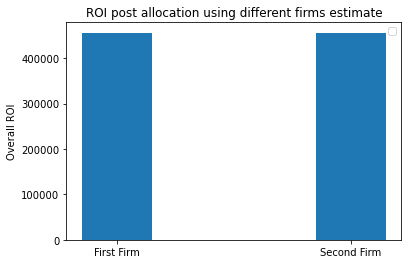

In [358]:
# plotting overall ROI
plt.bar(['First Firm', 'Second Firm'], [first_firms_roi, second_firms_roi], width=width)
plt.ylabel('Overall ROI')
plt.title('ROI post allocation using different firms estimate')
plt.legend()
plt.savefig('figure/total_roi_for_different_estiamtes.jpeg')
plt.show()

**Removing the third constrained put by the boss and checking the allocation**

In [152]:
# updating constraint limit vector
b_unconstrained = b.copy()
b_unconstrained[2:13] = 1

# creating the two models
adv_model_unconstrained1 = create_model(A, sense, b_unconstrained, obj=roi, opt=gp.GRB.MAXIMIZE)
adv_model_unconstrained2 = create_model(A, sense, b_unconstrained, obj=second_roi, opt=gp.GRB.MAXIMIZE)

# creating an output df with different firms ROI for Platform allocation
output_unconstrained_df = roi_df.T.reset_index()
output_unconstrained_df.columns = output_unconstrained_df.iloc[0]
output_unconstrained_df = output_unconstrained_df.iloc[1:]

# creating new column in output df for budget allocation
output_unconstrained_df['Allocation'] = adv_model_unconstrained1.x
output_unconstrained_df['Second Allocation'] = adv_model_unconstrained2.x

# overall ROI after removing the third constraint
first_firms_unconstrained_roi_pct = round(adv_model_unconstrained1.objVal*100,3)
first_firms_unconstrained_roi = round(adv_model_unconstrained1.objVal*total_budget)
print('Total ROI from ${} marketing budget is {} dollars which is {}%'.format(
    total_budget, first_firms_unconstrained_roi, first_firms_unconstrained_roi_pct))

second_firms_unconstrained_roi_pct = round(adv_model_unconstrained2.objVal*100,3)
second_firms_unconstrained_roi = round(adv_model_unconstrained2.objVal*total_budget)
print('Total ROI from ${} marketing budget is {} dollars which is {}%'.format(
    total_budget, second_firms_unconstrained_roi, second_firms_unconstrained_roi_pct))

Total ROI from $10000000 marketing budget is 465000 dollars which is 4.65%
Total ROI from $10000000 marketing budget is 465000 dollars which is 4.65%


<ipython-input-152-13f17cccf20e>:6: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  adv_model_unconstrained1 = create_model(A, sense, b_unconstrained, obj=roi, opt=gp.GRB.MAXIMIZE)
<ipython-input-152-13f17cccf20e>:7: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  adv_model_unconstrained2 = create_model(A, sense, b_unconstrained, obj=second_roi, opt=gp.GRB.MAXIMIZE)


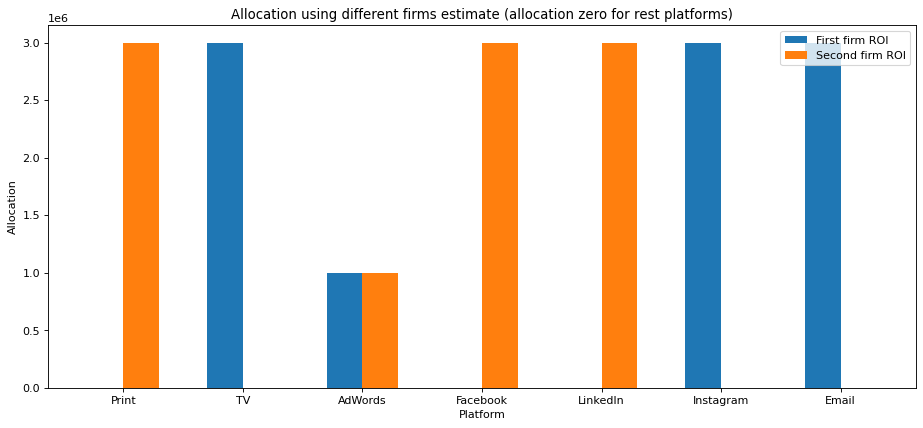

In [359]:
# plotting different firm allocation
plt.figure(figsize=(14, 6), dpi=80)
allocation_unconstrained_df = output_unconstrained_df.loc[
    (output_unconstrained_df['Allocation'] > 0) | (output_unconstrained_df['Second Allocation'] > 0) ,
    ['Platform', 'Allocation', 'Second Allocation']]

width = 0.3
ind = ind = np.arange(len(allocation_df))
plt.xticks(ind + width / 2, allocation_df['Platform'])
plt.bar(ind, allocation_df['Allocation']*total_budget, label='First firm ROI', width=width)
plt.bar(ind + width, allocation_df['Second Allocation']*total_budget, label='Second firm ROI', width=width)

plt.xlabel('Platform')
plt.ylabel('Allocation')
plt.title('Allocation using different firms estimate (allocation zero for rest platforms)')
plt.legend()
plt.savefig('figure/third_constrained_removed_allocation.jpeg')
plt.show()

**Conclusion -** 

Optimal allocation obtained via linear optimization from *different firms estimates end up giving the same ROI*. Although the *budget allocation of differnet platforms varies*. The two allocation vary between online platform - one giving more value to *Facebook & Linkedin* while the other to *Instagram & Email*. They also vary between traditional platform *TV vs Print*. Though the allocation for both firms is same for *AdWords*

Given the uncertainity in ROI estimates and the objective of maintaining presence over various platforms it makes sense to put the third constraints imposed by the boss. If that constraint is removed, almost all of the budget will be allocated to the platform which gives the highest ROI.
If we remove that constraint, for first ROI we get TV & Email as 50-50%, and for second its Print & Facebook.

## Sensitivity analysis

To explore this further perform some analysis of how your optimal allocation would change based on changes in the ROI data.  Use the first ROI data as your starting point.  By how much could each advertising medium’s ROI increase or decrease and still result in the same optimal allocation you found in step (3)?

**How to perform sensitivity analysis** - 

* ROI will be modified for each platform one by one without changing it for the other platforms
* Optimal Allocation and Objective value will be recorded to identify till it stays the same

In [156]:
# getting first allocation vector for comparision
allocation1 = output_df['Allocation'].values

# creating senstivity df
sensitivity1 = pd.DataFrame(data=None, columns=['Platform', 'ROI', 'Total ROI', 'Allocation'])

# looping over for getting optimal allocation
for i in range(1, roi_df.shape[1]):
    
    # platform name
    platform = roi_df.columns[i]
    platform_roi = roi_df[platform].values[0]
    
    # looping over for range in ROI
    # print(platform, platform_roi)
    s_allocation = allocation1.copy()
    new_roi = roi.copy()
    
    # for decreasing the platform ROI
    while (np.array_equal(allocation1, s_allocation) & (new_roi[i-1] > 0)):
        
        new_roi[i-1] -= 0.001
        
        s_model = create_model(A, sense, b, obj=new_roi, opt=gp.GRB.MAXIMIZE)
        s_allocation = s_model.x
        
        if np.array_equal(allocation1, s_allocation):
            row_len = len(sensitivity1)
            sensitivity1.loc[row_len, 'Platform'] = platform
            sensitivity1.loc[row_len, 'ROI'] = new_roi[i-1]
            sensitivity1.loc[row_len, 'Total ROI'] = s_model.objVal
            sensitivity1.loc[row_len, 'Allocation'] = str(s_allocation)
    
    # for increasing the platform ROI
    s_allocation = allocation1.copy()
    new_roi = roi.copy()
    
    while (np.array_equal(allocation1, s_allocation) & (new_roi[i-1] < 0.1)):
        
        new_roi[i-1] += 0.001
        
        s_model = create_model(A, sense, b, obj=new_roi, opt=gp.GRB.MAXIMIZE)
        s_allocation = s_model.x
        
        if np.array_equal(allocation1, s_allocation):
            row_len = len(sensitivity1)
            sensitivity1.loc[row_len, 'Platform'] = platform
            sensitivity1.loc[row_len, 'ROI'] = new_roi[i-1]
            sensitivity1.loc[row_len, 'Total ROI'] = s_model.objVal
            sensitivity1.loc[row_len, 'Allocation'] = str(s_allocation)


Print 0.031


<ipython-input-156-493bf768fae3>:24: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  s_model = create_model(A, sense, b, obj=new_roi, opt=gp.GRB.MAXIMIZE)
<ipython-input-156-493bf768fae3>:42: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  s_model = create_model(A, sense, b, obj=new_roi, opt=gp.GRB.MAXIMIZE)


TV 0.049
SEO 0.024
AdWords 0.039
Facebook 0.016
LinkedIn 0.024
Instagram 0.046
Snapchat 0.026
Twitter 0.033
Email 0.044


In [162]:
# assertion check, there could be only one optimal allocation which is the optimal allocation
assert sensitivity1[['Allocation']].drop_duplicates().shape[0] == 1
del sensitivity1['Allocation']

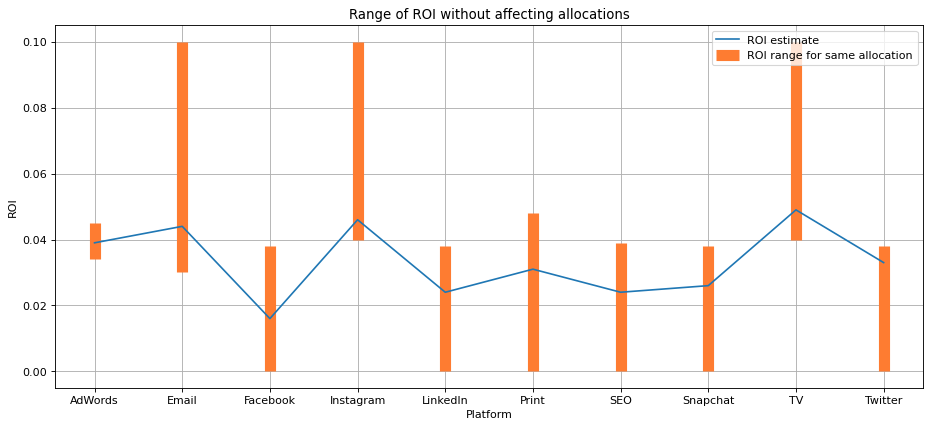

In [360]:
# creating dict for visualisation
sensitivity_agg = sensitivity1.groupby(['Platform']).agg({'ROI':['min', 'max']})
sensitivity_agg['Actual ROI'] = roi_df.T.loc[sensitivity_agg.index][0]
sensitivity_dict = {}
for pf in sensitivity_agg.index:
    sensitivity_dict[pf] = tuple(sensitivity_agg.loc[pf, [('ROI', 'min'), ('ROI', 'max')]].values)
    

# plot size
plt.figure(figsize=(14, 6), dpi=80)

for i, values in enumerate(sensitivity_dict.values()):
    ymin, ymax = values
    plt.vlines(i, ymin=ymin, ymax=ymax, lw=10, color='#fe7c31')

# plotting the first ROI line
plt.plot(np.arange(len(sensitivity_agg)), sensitivity_agg['Actual ROI'])

# to illustrate that ranges are properly drawn
plt.grid(True)

# add ticks 
plt.xticks(np.arange(0, len(sensitivity_agg)), list(sensitivity_dict.keys()))

# adding title and axis names
plt.xlabel('Platform')
plt.ylabel('ROI')
plt.title('Range of ROI without affecting allocations')
plt.legend(['ROI estimate', 'ROI range for same allocation'])
plt.savefig('figure/sensitivity_analysis.jpeg')
plt.show()

## Monthly incremental allocation & Stable budget

Your boss has gained permission to reinvest half of the return. For example, if the marketing obtains a 4% return in January, the budget of February will be $10M + $10M × 4% × 50% = $10.2M.  The monthly ROI for next year is given in Project1.Rdata. The three constraints given by your boss are still in place for each month.  What is the optimal allocation for each month?

**Assuming Total budget given - $10M, is monthly & using ROI from first firm**

In [308]:
# creating monthly budget var to be updated every month
monthly_budget = [0]*13
monthly_budget[0] = total_budget
months = np.arange(1, 13)
month_name = [calendar.month_name[m] + ' ' + 'Allocation' for m in months]

# creating output df
monthly_allocation_df = pd.DataFrame(data=None, columns=(['Platform'] + month_name))
monthly_allocation_df['Platform'] = output_df['Platform']

# calculating allocation for every month
for m in months:
    
    # updating constraint for varying monthly budget
    b_monthly = b.copy()
    for i in range(10):
        b_monthly[i+2] = 0.3*total_budget/monthly_budget[m-1]

    # creating the model and storing in output dataframe
    adv_month_model = create_model(A, sense, b_monthly, obj=roi, opt=gp.GRB.MAXIMIZE)
    monthly_allocation_df.iloc[:, m] = adv_month_model.x 
    monthly_allocation_df.iloc[:, m] =  monthly_allocation_df.iloc[:, m] * monthly_budget[m-1]
    
    # updating budget
    monthly_budget[m] = (1 + adv_month_model.objVal * 0.5) * monthly_budget[m-1]

<ipython-input-308-571f59b92d26>:20: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  adv_month_model = create_model(A, sense, b_monthly, obj=roi, opt=gp.GRB.MAXIMIZE)


In [353]:
adv_month_model.SAObjLow

[-inf,
 0.035,
 -inf,
 0.033,
 -inf,
 -inf,
 0.033,
 -inf,
 0.026999999999999996,
 0.035]

In [336]:
monthly_allocation_df

,Platform,January Allocation,February Allocation,March Allocation,April Allocation,May Allocation,June Allocation,July Allocation,August Allocation,September Allocation,October Allocation,November Allocation,December Allocation
1,Print,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,TV,3000000.0,3000000.0,3000000.0,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06
3,SEO,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,AdWords,1000000.0,1228000.0,1460446.0,1.565808e+06,1.646210e+06,1.728019e+06,1.811259e+06,1.895956e+06,1.982135e+06,2.069822e+06,2.159044e+06,2.249828e+06
5,Facebook,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6,LinkedIn,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7,Instagram,3000000.0,3000000.0,3000000.0,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06
8,Snapchat,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
9,Twitter,0.0,0.0,0.0,1.316165e+05,2.924198e+05,4.560371e+05,6.225177e+05,7.919118e+05,9.642703e+05,1.139645e+06,1.318089e+06,1.499655e+06
10,Email,3000000.0,3000000.0,3000000.0,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06


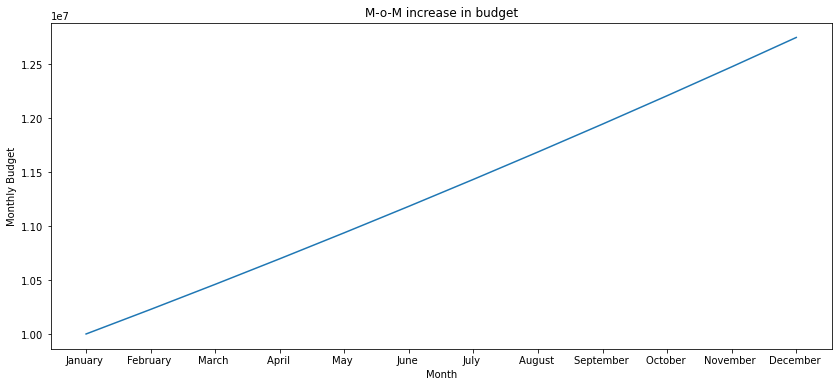

In [361]:
# plotting each months budget
plt.figure(figsize=(14, 6))
plt.plot(monthly_allocation_df.columns[1:].str.replace('Allocation',''), monthly_budget[:-1])

# adding title and axis names
plt.xlabel('Month')
plt.ylabel('Monthly Budget')
plt.title('M-o-M increase in budget')
plt.savefig('figure/mom_increase.jpeg')
plt.show()

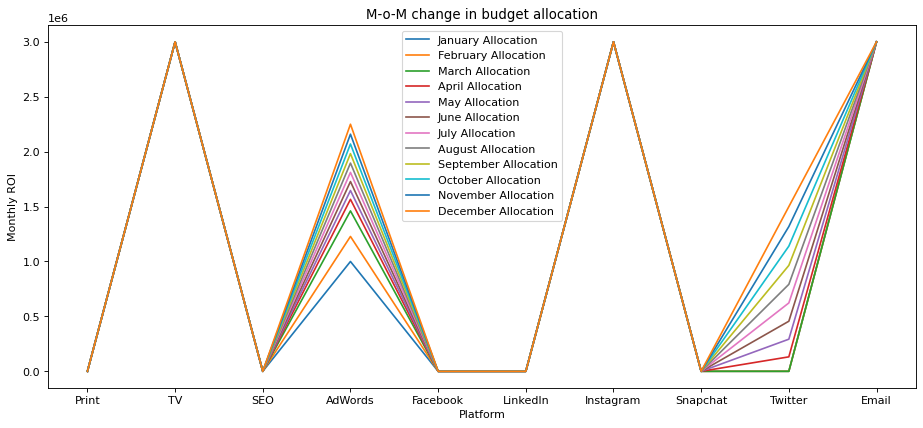

In [362]:
# plot size
plt.figure(figsize=(14, 6), dpi=80)

# plotting each months allocation
for i in months:
    plt.plot(monthly_allocation_df.iloc[:, 0].values, monthly_allocation_df.iloc[:, i].values, 
             label=monthly_allocation_df.columns[i])


# adding title and axis names
plt.xlabel('Platform')
plt.ylabel('Monthly ROI')
plt.title('M-o-M change in budget allocation')
plt.legend()
plt.savefig('figure/mom_allocation_change.jpeg')
plt.show()

A *stable budget* is defined as a monthly allocation such that for each platform the monthly change in spend is no more than $1M. Is the allocation you found stable? If it isn’t, you do not need to solve a new optimization model.  Describe how my might model this?

**M-o-M allocation change for every platfrom is well below $1M, hence the allocation can be said to be a stable budget.**